<span style="font-size:30px;"> This notebook also includes small random shifts in layer stackings

In [2]:
import ase
import abtem
import matplotlib.pyplot as plt
from ase.io import read, write
from ase.spacegroup import get_spacegroup
import numpy as np
from scipy.ndimage import center_of_mass as com
import random
import math

from utils import apply_wrinkle_with_strain, make_monolayer,apply_wrinkle

# Build substructures for analysis

## Large blocks from cif

In [ ]:
W,H,Thick = 20,10,0
NaPHI_insights_cif = read("/Users/danielkh/Downloads/cm9b02199_si_002_vesta.cif")
PHI_cif_periodic = NaPHI_Model1_cif*(W,H,Thick)
#PHI_cif_periodic = NaPHI_insights_cif*(W,H,Thick)

In [ ]:
abtem.show_atoms(PHI_cif_periodic,'yz',show_periodic=True)

## monolayers,

In [96]:
W,H = 6, 6
cif_path = "/Users/danielkh/Documents/Nadja/Na_PHI_model_2/NA_PHI_model_2.cif"
PHI_monolayer1 = make_monolayer(W,H,"/Users/danielkh/Documents/Nadja/Na_PHI_model_1/NA_PHI_model_1.cif")
PHI_monolayer2 = make_monolayer(W,H,"/Users/danielkh/Documents/Nadja/Na_PHI_model_2/NA_PHI_model_2.cif")

In [97]:
# Get unique atom types
unique_types = set(PHI_monolayer2.get_chemical_symbols())

print(unique_types)

{'Na', 'C', 'N'}


In [98]:
PHI_monolayer2_noNa = ase.Atoms([atom for atom in PHI_monolayer2 if atom.symbol != 'Na'])

In [99]:
# Get unique atom types
unique_types = set(PHI_monolayer2_noNa.get_chemical_symbols())

print(unique_types)

{'C', 'N'}


In [100]:
PHI_monolayer2_noNa.cell = PHI_monolayer2.cell

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

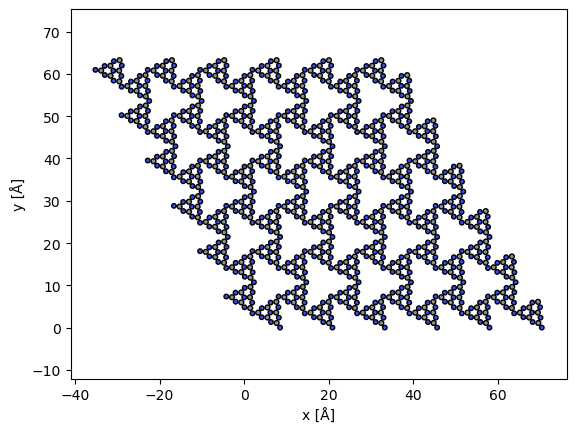

In [101]:
abtem.show_atoms(PHI_monolayer2_noNa,'xy',show_cell=False)

## ribbons

## spacegrup

In [ ]:
# Analyze symmetry using spglib
spacegroup = get_spacegroup(PHI_cif_periodic)

# Print the space group
print(f"Space group: {spacegroup}")

# Additional Transformations

# Build layer-by-layer

## Deformations

In [116]:

import numpy as np
from ase.io import read

# ========= You provide these =========
cif_path  = "/Users/danielkh/Documents/Nadja/Na_PHI_model_2/NA_PHI_model_2.cif"   # primitive CIF path
monolayer = PHI_monolayer2_noNa             # your already-built (super)cell (ASE Atoms)
# =====================================

# -------------------------- User Controls --------------------------
# Waves (in-layer wrinkles)
wave = 0
rand_wave = 0
rand_amp  = 0
WL_coeff  = 2
amplitude = 0.5

# Rotations (between layers)
rot      = 0
rand_rot = 0

# Stacking
layer_spacing = 3.3668
num_layers    = 50

# In-plane shifts (between layers)
# NOTE: "random_continuous" will APPLY even if use_diagonal_shift == False
use_diagonal_shift = False
## Random shifts added
shift_dir_mode     = "random_continuous"   # NEW mode; legacy: "diag", "triangular_6", "triangular_3"
small_random_shift_max_frac = 0.2         # e.g., 0.05 * |a|  (≪ 1/3 * |a|)
##

# Legacy params (kept for backward compatibility; mostly ignored by "random_continuous")
diag_sign          = +1               # used when mode == "diag" and random_shift_dir == 0
base_shift_axis    = "a"              # used if triangular mode + not random; {"a","b","a-b"}
diag_shift_frac    = 1/3              # fraction of primitive step per layer (legacy modes)
cumulative_shift   = False            # ensure no modulo wrapping; non-periodic when legacy modes used
random_shift_dir   = 0                # 0=fixed, 1=random per layer (legacy modes)
# -------------------------------------------------------------------

# Buckling / Dome (optional; zero at edges, max at center)
buckle                 = 0
buckle_amplitude_A     = 10.0
buckle_center_mode     = "COM"        # "COM", "origin", or "fixed"
buckle_center_xy       = (0.0, 0.0)
buckle_profile         = "cos_prod"   # "cos_prod" or "paraboloid"

# ===== Full Curving (uniform curvature over the whole layer) =====
curve              = 0          # 1 -> apply, 0 -> off
bend_axis          = "y"        # "x" or "y" (only one axis allowed)
bend_factor        = 0.5        # 0..1  (0 flat, 1 closes into a tube)
bend_sign          = +1         # +1 convex (+z), -1 concave
curve_center_mode  = "COM"      # "COM", "origin", or "fixed"
curve_center_xy    = (0.0, 0.0) # used when mode == "fixed"
# ==================================================================

# Reproducibility
seed = 42
# -------------------------------------------------------------------

# Guards
if wave == 1 and rand_wave == 1:
    raise ValueError("You have both specific and random_wave on.")
if rot == 1 and rand_rot == 1:
    raise ValueError("You have both specific and random_rot on.")
if bend_axis.lower() not in ("x","y"):
    raise ValueError("bend_axis must be 'x' or 'y'")
if not (0.0 <= bend_factor <= 1.0):
    raise ValueError("bend_factor must be in [0,1]")
if small_random_shift_max_frac < 0.0:
    raise ValueError("small_random_shift_max_frac must be non-negative")

# ---- Primitive reference from CIF (used for wavelength + shift directions) ----
prim = read(cif_path)
CIF_unitcell = float(prim.cell[0][0])             # primitive |a|
shift_ref_a  = np.array(prim.cell[0], dtype=float); shift_ref_a[2] = 0.0
shift_ref_b  = np.array(prim.cell[1], dtype=float); shift_ref_b[2] = 0.0

# Base rotation angle
base_rot_ang = 5 if rot == 1 else 0

# RNG and per-layer random choices
rng = np.random.default_rng(seed)
param_choice       = rng.integers(0, 3, size=num_layers)     # {0,1,2} for waves
rand_rotation_angs = rng.integers(0, 9, size=num_layers)     # 0..8 deg
rand_diag_signs    = rng.choice([-1, +1], size=num_layers)   # for "diag" random sign
rand_basis_idx     = rng.integers(0, 3, size=num_layers)     # 0->a, 1->b, 2->(a-b)
rand_basis_sgn     = rng.choice([-1, +1], size=num_layers)   # sign for triangular_6

# NEW: for "random_continuous" shift mode (small, non-periodic)
rand_angles = rng.uniform(0.0, 2.0*np.pi, size=num_layers)   # direction θ per layer
rand_mags   = rng.uniform(0.0, small_random_shift_max_frac, size=num_layers)  # fraction of |a|
# -------------------------------------------------------------------

# ---------------------------- Helpers -----------------------------
def get_rotation_angle(layer_idx: int) -> float:
    if rand_rot == 1:
        return float(rand_rotation_angs[layer_idx])
    if rot == 1 and layer_idx > num_layers // 2:
        return float(base_rot_ang)
    return 0.0

def get_wave_params(layer_idx: int):
    if not (wave == 1 or rand_wave == 1):
        return False, None, None
    wavelength = CIF_unitcell * WL_coeff
    local_amp  = amplitude
    if rand_wave == 1 and rand_amp == 1:
        ch = int(param_choice[layer_idx])
        local_amp = amplitude * (0.9 if ch == 0 else 1.0 if ch == 1 else 1.1)
    return True, wavelength, local_amp

def _pick_triagonal_basis(idx: int):
    # 0->a, 1->b, 2->(a-b)   (primitive vectors)
    return shift_ref_a if idx == 0 else shift_ref_b if idx == 1 else (shift_ref_a - shift_ref_b)

def get_inplane_shift(layer_idx: int) -> np.ndarray:
    """
    In-plane shift per layer.

    NEW mode "random_continuous": small, non-periodic, random direction & magnitude
    in the xy-plane. This mode ALWAYS applies, even if use_diagonal_shift == False.

    Legacy modes ("diag", "triangular_6", "triangular_3") still respect use_diagonal_shift.
    """
    mode = shift_dir_mode.lower()

    # --- NEW: small, non-periodic random shifts (always on for this mode) ---
    if mode in ("random_continuous", "rand_cont", "random"):
        mag_A = float(rand_mags[layer_idx]) * CIF_unitcell   # small magnitude in Å
        theta = float(rand_angles[layer_idx])
        dx = mag_A * np.cos(theta)
        dy = mag_A * np.sin(theta)
        return np.array([dx, dy, 0.0], dtype=float)

    # --- LEGACY BEHAVIOR BELOW (gated by use_diagonal_shift) ---
    if not use_diagonal_shift:
        return np.zeros(3, dtype=float)

    if mode == "diag":
        sign = int(rand_diag_signs[layer_idx]) if random_shift_dir == 1 else int(diag_sign)
        d_vec = shift_ref_a + sign * shift_ref_b
    elif mode in ("triangular_6", "triangular_3"):
        if random_shift_dir == 1:
            base = _pick_triagonal_basis(int(rand_basis_idx[layer_idx]))
            d_vec = int(rand_basis_sgn[layer_idx]) * base if mode == "triangular_6" else base
        else:
            base = {"a": shift_ref_a, "b": shift_ref_b, "a-b": shift_ref_a - shift_ref_b}[base_shift_axis.lower()]
            d_vec = base
    else:
        raise ValueError(f"Unknown shift_dir_mode: {shift_dir_mode}")

    # Legacy magnitude rule
    if random_shift_dir == 1 or cumulative_shift:
        frac = (layer_idx * diag_shift_frac) % 1.0
    else:
        frac = layer_idx * diag_shift_frac

    shift_vec = frac * d_vec
    shift_vec[2] = 0.0
    return shift_vec

def get_center_xy(layer_atoms, mode, fixed_xy):
    m = mode.upper()
    if m == "COM":
        cx, cy, _ = layer_atoms.get_center_of_mass()
        return np.array([cx, cy])
    elif m == "ORIGIN":
        return np.array([0.0, 0.0])
    elif m == "FIXED":
        x0, y0 = fixed_xy
        return np.array([float(x0), float(y0)])
    else:
        raise ValueError(f"Unknown center mode: {mode}")

def apply_full_buckle(coords, center_xy, amp_A, profile="cos_prod"):
    """Whole-layer dome: zero at edges, max at center (not constant curvature)."""
    new = coords.copy()
    x0, y0 = center_xy
    dx, dy = coords[:,0]-x0, coords[:,1]-y0
    half_Lx = max(np.max(dx), -np.min(dx)) + 1e-12
    half_Ly = max(np.max(dy), -np.min(dy)) + 1e-12
    nx = np.clip(np.abs(dx)/half_Lx, 0, 1)
    ny = np.clip(np.abs(dy)/half_Ly, 0, 1)
    if profile == "paraboloid":
        dz = amp_A * (1 - nx**2) * (1 - ny**2)
    else:
        dz = amp_A * np.cos(0.5*np.pi*nx) * np.cos(0.5*np.pi*ny)
    new[:,2] += dz
    return new

# ===== Full-layer uniform cylindrical curving with factor in [0,1] =====
def apply_uniform_bend(coords, center_xy, axis="x", factor=0.0, sign=+1):
    """
    Bend the whole layer cylindrically around a neutral line through (center_xy),
    using 'factor' in [0,1]: 0 = flat, 1 = closes into a tube (edges meet).
    Curvature k is derived from current layer size along the chosen axis:
        L = full width along axis about center_xy
        k = 2π * factor / L     (so factor=1 gives circumference 2πR = L)
        R = 1/k
    Mapping (length-preserving):
        if axis == 'x':
            s = x - x0
            x' = x0 + sin(k s)/k
            z' = z  + sign*(1 - cos(k s))/k
        elif axis == 'y':
            s = y - y0
            y' = y0 + sin(k s)/k
            z' = z  + sign*(1 - cos(k s))/k
    """
    new = coords.copy()
    x0, y0 = float(center_xy[0]), float(center_xy[1])

    eps = 1e-12
    if axis.lower() == "x":
        s = coords[:,0] - x0
        half_L = max(np.max(s), -np.min(s)) + eps
        L = 2.0 * half_L
        k = (2.0 * np.pi * float(factor) / L) if factor > 0.0 else 0.0

        if abs(k) < 1e-12:
            return new  # flat

        theta = k * s
        new[:,0] = x0 + np.sin(theta)/k
        new[:,2] = new[:,2] + sign * (1.0 - np.cos(theta))/k
        return new

    elif axis.lower() == "y":
        s = coords[:,1] - y0
        half_L = max(np.max(s), -np.min(s)) + eps
        L = 2.0 * half_L
        k = (2.0 * np.pi * float(factor) / L) if factor > 0.0 else 0.0

        if abs(k) < 1e-12:
            return new  # flat

        theta = k * s
        new[:,1] = y0 + np.sin(theta)/k
        new[:,2] = new[:,2] + sign * (1.0 - np.cos(theta))/k
        return new

    else:
        raise ValueError("axis must be 'x' or 'y'")
# -------------------------------------------------------------------

# ------------------------- Build Multilayer ------------------------
PHI_multilayer = None

for layer in range(num_layers):
    layer_atoms = monolayer.copy()

    # z-stacking
    layer_atoms.positions[:, 2] += layer_spacing * layer

    # rotation
    angle = get_rotation_angle(layer)
    if angle != 0.0:
        layer_atoms.rotate('z', angle, center="COM")

    # waves
    apply_wave, wavelength, local_amp = get_wave_params(layer)
    if apply_wave:
        # NOTE: assumes you have apply_wrinkle_with_strain(...) defined/imported elsewhere.
        wrinkled_coords = apply_wrinkle_with_strain(layer_atoms.positions,
                                                    wavelength=wavelength,
                                                    amplitude=local_amp,
                                                    axis="y")
        layer_atoms.positions = wrinkled_coords

    # buckling (optional, non-constant curvature dome)
    if buckle == 1:
        center_xy = get_center_xy(layer_atoms, buckle_center_mode, buckle_center_xy)
        layer_atoms.positions = apply_full_buckle(layer_atoms.positions,
                                                  center_xy=center_xy,
                                                  amp_A=buckle_amplitude_A,
                                                  profile=buckle_profile)

    # in-plane shift (NEW: random_continuous applies regardless of use_diagonal_shift)
    layer_atoms.positions += get_inplane_shift(layer)

    # full curving (uniform cylindrical bend, axis-only, factor in [0,1])
    if curve == 1 and bend_factor > 0.0:
        center_xy = get_center_xy(layer_atoms, curve_center_mode, curve_center_xy)
        layer_atoms.positions = apply_uniform_bend(layer_atoms.positions,
                                                   center_xy=center_xy,
                                                   axis=bend_axis,
                                                   factor=bend_factor,
                                                   sign=bend_sign)

    # add to stack
    PHI_multilayer = layer_atoms if PHI_multilayer is None else (PHI_multilayer + layer_atoms)

# Keep your original behavior; keep a valid cell if you need PBC/wrap later.
PHI_multilayer.cell = [0, 0, 0]
# -------------------------------------------------------------------


In [117]:
PHI_multilayer.cell

Cell([0.0, 0.0, 0.0])

(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='z [Å]'>)

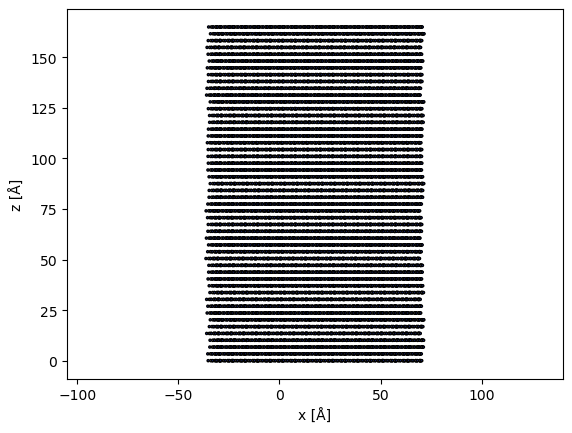

In [104]:
abtem.show_atoms(PHI_multilayer,'xz',show_cell=True)
# Save the current figure
#plt.savefig("atoms_abc_rot5deg_90yview.png", dpi=300, bbox_inches='tight')

In [ ]:
abtem.show_atoms(PHI_multilayer,'xy')

In [ ]:
write("./tmp/test_shifts.xyz",PHI_multilayer)

# Simulate 

In [121]:
#Angle for rotation
angle = 90
axis = 'y'

structure = PHI_multilayer.copy()
#structure = NaPHI_model2_cifdiff.copy()
structure.rotate(axis,angle,center="COM")
#structure.rotate('z',90,center="COM")
structure.center(vacuum=100)
frozen_phonons = abtem.FrozenPhonons(structure, 10, sigmas=0.5)
potential = abtem.Potential(
    #frozen_phonons,
    structure,
    #sampling=0.05,
    gpts=1024,
    projection="finite",
    slice_thickness=1,
    periodic=True,
    )
wave = abtem.Probe(energy=200e3, semiangle_cutoff=0.2)#,sampling = 0.0563)
wave.grid.match(potential)
measurement = wave.multislice(potential).diffraction_patterns(max_angle=30)
#diff = measurement.compute()
Diffraction_multilayer = measurement.compute()
#Diffraction_waves_thick= measurement.compute()

[########################################] | 100% Completed | 42.42 ss


(<Figure size 640x480 with 1 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

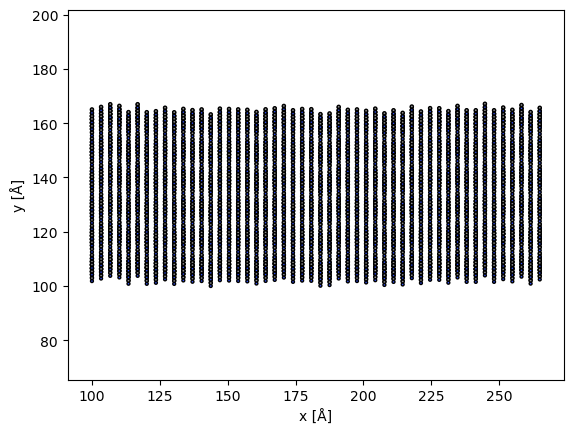

In [122]:
abtem.show_atoms(structure,'xy',show_cell=False)

#noisey_diff = Diffraction_multilayer.poisson_noise(total_dose = 600000)

/var/folders/c0/5mwb73ts6470d8mcgd0ms4z00000gn/T/ipykernel_3972/1327736205.py:2: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


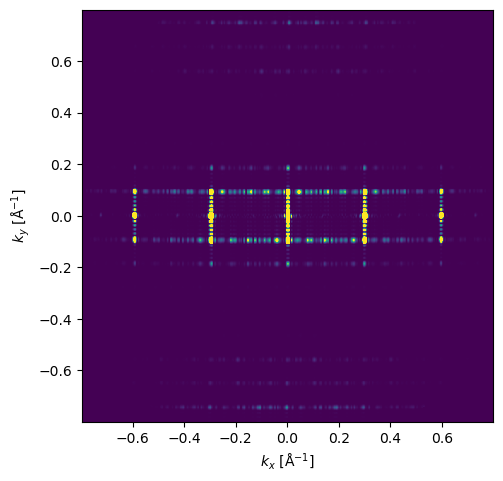

In [124]:
noisey_diff_img = Diffraction_multilayer.crop(20).show(vmax=1e-5)
plt.tight_layout()

ONE-CELL abTEM diffraction & structure save


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import abtem

# ---------------- config ----------------
BASE   = PHI_multilayer.copy()   # or NaPHI_model2_cifdiff.copy()
PREFIX = "waves"                  # e.g. "waves", "abc", "aaa"
OUTDIR = Path("abtem_zone_axes")
OUTDIR.mkdir(exist_ok=True)

# abTEM conditions
ENERGY = 200e3
SEMIANGLE = 0.2           # mrad
MAX_SCATTER_ANGLE = 30    # mrad
SLICE_THICKNESS = 1.0     # Å
GPTS = 1024

# make sure we have a real cell
BASE.center(vacuum=100.0)

# list of zone axes
zone_axes = [
    ("[100]", (1, 0, 0)),
    ("[010]", (0, 1, 0)),
    ("[001]", (0, 0, 1)),
    ("[110]", (1, 1, 0)),
    ("[101]", (1, 0, 1)),
    ("[011]", (0, 1, 1)),
    ("[111]", (1, 1, 1)),
]

def _normalize(v):
    n = np.linalg.norm(v)
    return v / n if n > 1e-12 else v

def rotate_to_hkl(structure, hkl):
    """Rotate structure so [hkl] || +z, assuming default [001] || +z initially."""
    s = structure.copy()
    cell = np.array(s.cell)
    h, k, l = hkl
    a, b, c = cell
    target = _normalize(h*a + k*b + l*c)
    ez = np.array([0.0, 0.0, 1.0])
    axis = np.cross(ez, target)
    axis_n = np.linalg.norm(axis)
    if axis_n > 1e-12:
        axis /= axis_n
        angle = np.degrees(np.arccos(np.clip(np.dot(ez, target), -1.0, 1.0)))
        s.rotate(v=axis, a=angle, center="COM")
    s.center(vacuum=100.0)
    return s

for label, hkl in zone_axes:
    # --- orient
    s = rotate_to_hkl(BASE, hkl)

    # --- potential
    potential = abtem.Potential(
        s,
        gpts=GPTS,
        projection="finite",
        slice_thickness=SLICE_THICKNESS,
        periodic=True,
    )

    # --- probe & diffraction
    probe = abtem.Probe(energy=ENERGY, semiangle_cutoff=SEMIANGLE)
    probe.grid.match(potential)
    dp = probe.multislice(potential).diffraction_patterns(max_angle=MAX_SCATTER_ANGLE).compute()

    # filenames
    base_name = f"{PREFIX}_{label.strip('[]')}"
    png_diff  = OUTDIR / f"{base_name}_diff.png"
    npy_diff  = OUTDIR / f"{base_name}.npy"
    png_atoms = OUTDIR / f"{base_name}_atoms.png"

    # 1) diffraction pattern PNG
    fig, ax = plt.subplots(figsize=(5,5), dpi=300)
    dp.show(ax=ax,vmax=1e-6)
    ax.set_title(label, fontsize=10)
    fig.tight_layout()
    fig.savefig(png_diff, bbox_inches="tight")
    plt.close(fig)

    # 2) diffraction pattern raw intensities as .npy
    data = dp.array if hasattr(dp, "array") else dp.data
    np.save(npy_diff, data)

    # 3) projected atoms PNG
    fig2, ax2 = plt.subplots(figsize=(5,5), dpi=300)
    abtem.show_atoms(s, 'xy', show_cell=False, ax=ax2)
    fig2.tight_layout()
    fig2.savefig(png_atoms, bbox_inches="tight")
    plt.close(fig2)

print(f"Done. Results saved in: {OUTDIR.resolve()}")


[########################################] | 100% Completed | 43.22 ss
[########################################] | 100% Completed | 54.60 ss
[########################################] | 100% Completed | 51.01 ss
[########################################] | 100% Completed | 39.65 ss
[########################################] | 100% Completed | 45.04 ss
[########################################] | 100% Completed | 39.90 ss
[########################################] | 100% Completed | 38.86 ss
Done. Results saved in: /Users/danielkh/PHI/scripts/abtem_zone_axes


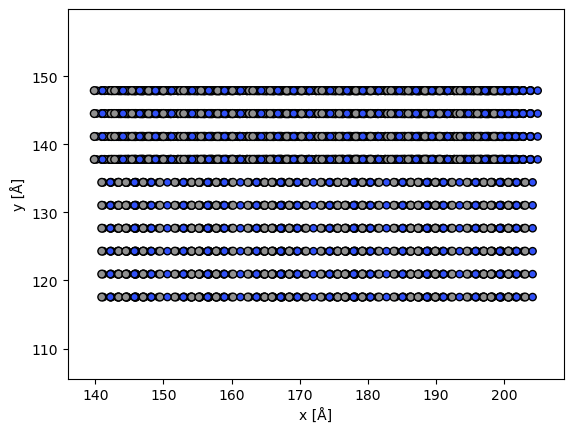

In [854]:
import abtem
import matplotlib.pyplot as plt

# rotate a copy so you don't modify your original structure
rotated = structure.copy()
rotated.rotate(90, v='y', center='COM')   # 45° about z; use 'x' or 'y' to “tilt”
rotated.rotate(90, v='z', center='COM')

# Show atoms
abtem.show_atoms(rotated,'xy', show_cell=False)

# Save the current figure
plt.savefig("atoms_aaa_rot5deg_90yview.png", dpi=300, bbox_inches='tight')
